In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 材料参数
G0 = 1.0       # 弹性模量
tau = 1.0      # 松弛时间

# 时间参数
t_start = 0.0
T = 2 * np.pi
t_end = 2 * T
num_points = 1000
time = np.linspace(t_start, t_end, num_points)
dt = time[1] - time[0]

# 剪切应变振幅序列
gamma0_list = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]

# 初始化存储结果
results = {
    'gamma0': gamma0_list,
    'N1': [],  # 存储每个 gamma0 对应的 N1
    'sigma12': []  # 存储每个 gamma0 对应的 sigma12
}

# 对每个 gamma0 进行数值模拟
for gamma0 in gamma0_list:
    # 剪切应变函数
    omega = 2 * np.pi / T
    gamma = gamma0 * np.sin(omega * time)

    # 初始化应力分量
    sigma11 = np.zeros_like(time)
    sigma22 = np.zeros_like(time)
    sigma12 = np.zeros_like(time)

    # 数值积分计算应力
    for i, t in enumerate(time):
        for j in range(i):
            t_prime = time[j]
            gamma_diff = gamma[i] - gamma[j]
            exp_term = np.exp(-(t - t_prime) / tau)
            
            # 取向张量函数 Q
            Q11 = (1 + gamma_diff**2) / (2 + gamma_diff**2)
            Q12 = gamma_diff / (2 + gamma_diff**2)
            Q22 = 1 / (2 + gamma_diff**2)
            
            # 应力积分
            sigma11[i] += G0 * exp_term * Q11 * dt
            sigma22[i] += G0 * exp_term * Q22 * dt
            sigma12[i] += G0 * exp_term * Q12 * dt * 20

    # 计算第一法向应力差
    N1 = sigma11 - sigma22

    # 保存结果
    results['N1'].append(N1)
    results['sigma12'].append(sigma12)

# 输出结果
print("Results saved for gamma0 values:", results['gamma0'])



Results saved for gamma0 values: [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]


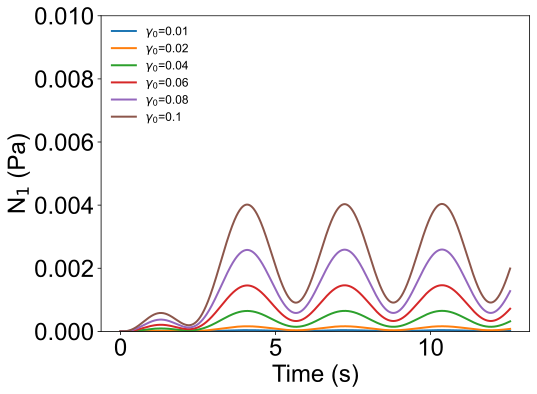

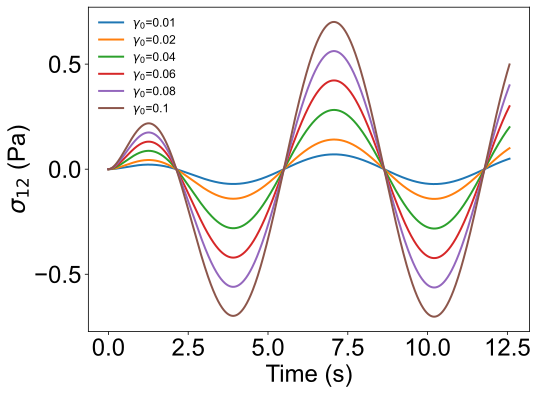

In [2]:
# 设置全局字体为 Arial，字号为 24
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
%config InlineBackend.figure_format = 'svg'

# 图 1: 第一法向应力差 N1 随时间的变化（多振幅）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    ax.plot(time, results['N1'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('N$_{1}$ (Pa)')
ax.set_ylim(0,0.01)
ax.legend(loc='upper left', frameon=False, fontsize=12)  # 添加图例
plt.tight_layout()
plt.show()

# 图 2: 剪切应力 σ12 随时间的变化（多振幅）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    ax.plot(time, results['sigma12'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.legend(loc='upper left', frameon=False, fontsize=12)  # 添加图例
plt.tight_layout()
plt.show()

- 绘制弹性lissajous曲线

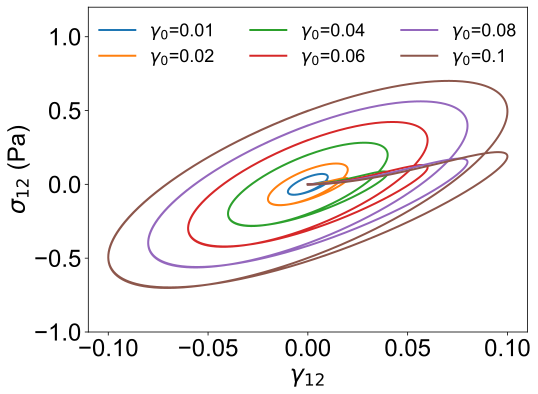

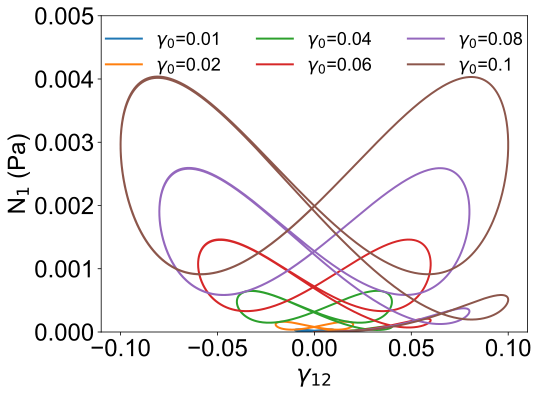

In [3]:
# 图 1: σ12 随剪切应变 γ 的变化（多振幅 Lissajous 曲线）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    gamma = gamma0 * np.sin(omega * time)  # 计算当前振幅的剪切应变
    ax.plot(gamma, results['sigma12'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('$\gamma_{12}$')
ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.set_ylim(-1, 1.2)
ax.legend(
    loc='upper center',          # 图例中心对齐
    ncol=3,                      # 图例分为 3 列
    frameon=False,               # 去除图例边框
    fontsize=18                  # 减小图例字体大小
)
plt.tight_layout()
plt.show()

# 图 2: N1 随剪切应变 γ 的变化（多振幅 Lissajous 曲线）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    gamma = gamma0 * np.sin(omega * time)  # 计算当前振幅的剪切应变
    ax.plot(gamma, results['N1'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('$\gamma_{12}$')
ax.set_ylabel('N$_{1}$ (Pa)')
ax.set_ylim(0, 0.005)
ax.legend(
    loc='upper center',          # 图例中心对齐
    ncol=3,                      # 图例分为 3 列
    frameon=False,               # 去除图例边框
    fontsize=18                  # 减小图例字体大小
)
plt.tight_layout()
plt.show()

## 绘制LAOS

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 材料参数
G0 = 1.0       # 弹性模量
tau = 1.0      # 松弛时间

# 时间参数
t_start = 0.0
T = 2 * np.pi
t_end = 2 * T
num_points = 1000
time = np.linspace(t_start, t_end, num_points)
dt = time[1] - time[0]

# 剪切应变振幅序列
gamma0_list = [1, 2, 4, 6, 8, 10]

# 初始化存储结果
results = {
    'gamma0': gamma0_list,
    'N1': [],  # 存储每个 gamma0 对应的 N1
    'sigma12': []  # 存储每个 gamma0 对应的 sigma12
}

# 对每个 gamma0 进行数值模拟
for gamma0 in gamma0_list:
    # 剪切应变函数
    omega = 2 * np.pi / T
    gamma = gamma0 * np.sin(omega * time)

    # 初始化应力分量
    sigma11 = np.zeros_like(time)
    sigma22 = np.zeros_like(time)
    sigma12 = np.zeros_like(time)

    # 数值积分计算应力
    for i, t in enumerate(time):
        for j in range(i):
            t_prime = time[j]
            gamma_diff = gamma[i] - gamma[j]
            exp_term = np.exp(-(t - t_prime) / tau)
            
            # 取向张量函数 Q
            Q11 = (1 + gamma_diff**2) / (2 + gamma_diff**2)
            Q12 = gamma_diff / (2 + gamma_diff**2)
            Q22 = 1 / (2 + gamma_diff**2)
            
            # 应力积分
            sigma11[i] += G0 * exp_term * Q11 * dt
            sigma22[i] += G0 * exp_term * Q22 * dt
            sigma12[i] += G0 * exp_term * Q12 * dt * 20

    # 计算第一法向应力差
    N1 = sigma11 - sigma22

    # 保存结果
    results['N1'].append(N1)
    results['sigma12'].append(sigma12)

# 输出结果
print("Results saved for gamma0 values:", results['gamma0'])



Results saved for gamma0 values: [1, 2, 4, 6, 8, 10]


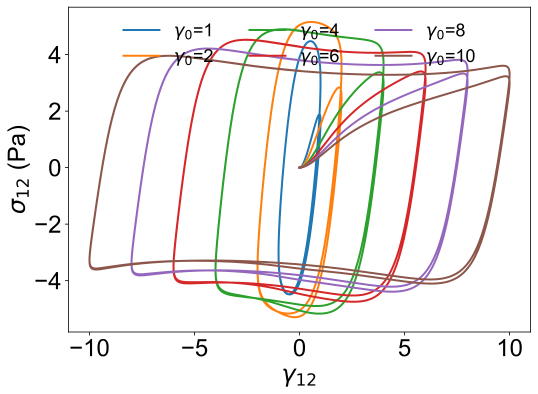

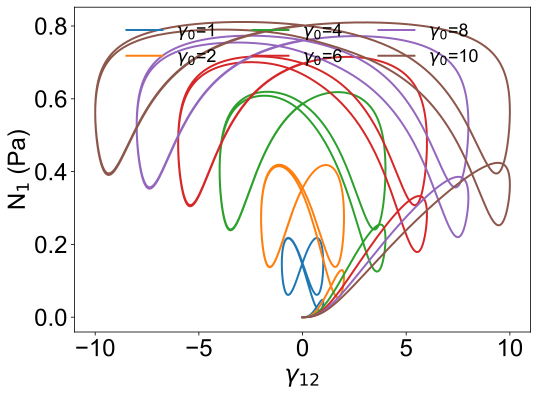

In [12]:
# 图 1: σ12 随剪切应变 γ 的变化（多振幅 Lissajous 曲线）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    gamma = gamma0 * np.sin(omega * time)  # 计算当前振幅的剪切应变
    ax.plot(gamma, results['sigma12'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('$\gamma_{12}$')
ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.legend(
    loc='upper center',          # 图例中心对齐
    ncol=3,                      # 图例分为 3 列
    frameon=False,               # 去除图例边框
    fontsize=18                  # 减小图例字体大小
)
plt.tight_layout()
plt.show()

# 图 2: N1 随剪切应变 γ 的变化（多振幅 Lissajous 曲线）
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)  # 画布大小为 8x6 英寸
for i, gamma0 in enumerate(results['gamma0']):
    gamma = gamma0 * np.sin(omega * time)  # 计算当前振幅的剪切应变
    ax.plot(gamma, results['N1'][i], label=f'$\gamma_0$={gamma0}', linewidth=2)
ax.set_xlabel('$\gamma_{12}$')
ax.set_ylabel('N$_{1}$ (Pa)')
ax.legend(
    loc='upper center',          # 图例中心对齐
    ncol=3,                      # 图例分为 3 列
    frameon=False,               # 去除图例边框
    fontsize=18                  # 减小图例字体大小
)
plt.tight_layout()
plt.show()